In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi

/Users/USER/Desktop/Side_project/transformer-classifier/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
api = KaggleApi()
api.authenticate()

In [3]:
api.competition_download_file('sentiment-analysis-on-movie-reviews', 'train.tsv.zip', path='./data')

train.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
with zipfile.ZipFile('./data/train.tsv.zip', 'r') as zipref:
    zipref.extractall('./data')

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('./data/train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
# df.drop_duplicates(subset='SentenceId', keep='first', inplace=True)
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [8]:
len(df)

156060

In [9]:
seqlen = df['Phrase'].apply(lambda x: len(x.split()))

In [10]:
import seaborn as sns 
import matplotlib.pyplot as plt

<Figure size 1000x1000 with 0 Axes>

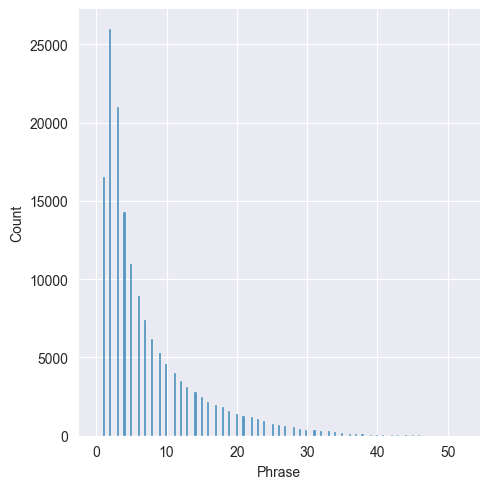

In [11]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 10))
sns.displot(seqlen)

In [12]:
SQL_LEN = 50

In [13]:
import torch
from transformers import AutoTokenizer

In [14]:
device = torch.device('mps')

In [15]:
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-base-en-v1.5")

In [16]:
tokens = tokenizer.encode_plus(text='hello world!', max_length=SQL_LEN, 
                               truncation=True, padding='max_length', 
                               add_special_tokens=True, return_token_type_ids=False, 
                               return_attention_mask=True, return_tensors='tf')

2024-02-11 22:18:52.679967: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-11 22:18:52.679986: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-11 22:18:52.679990: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-11 22:18:52.680386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-11 22:18:52.680759: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
tokens

{'input_ids': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[ 101, 7592, 2088,  999,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [18]:
import numpy as np

In [19]:
Xids = np.zeros((len(df), SQL_LEN))
Xmasks = np.zeros((len(df), SQL_LEN))

In [20]:
Xids.shape

(156060, 50)

In [21]:
for i, sentence in enumerate(df['Phrase']):
    tokens = tokenizer.encode_plus(text=sentence, max_length=SQL_LEN, 
                               truncation=True, padding='max_length', 
                               add_special_tokens=True, return_token_type_ids=False, 
                               return_attention_mask=True, return_tensors='tf')
    Xids[i, :], Xmasks[i, :] = tokens['input_ids'], tokens['attention_mask']

In [22]:
df['Sentiment'].unique()

array([1, 2, 3, 4, 0])

In [26]:
arr = df['Sentiment'].values
labels = np.zeros((arr.size, 3))

In [29]:
for idx, i in enumerate(arr):
    if i < 2:
        category = 0 
    elif i == 2:
        category = 1
    else:
        category = 2
    labels[idx, category] = 1

In [30]:
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [32]:
model_name = 'bge-base-en-v1.5-new'

In [33]:
np.save(f'./vectors/{model_name}/Xids.npy', Xids)
np.save(f'./vectors/{model_name}/Xmasks.npy', Xmasks)
np.save(f'./vectors/{model_name}/labels.npy', labels)